1- Setup & configuration

In [4]:
# --- cell: setup & configuration ---
import os, random
from pathlib import Path

import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# >>> set your Video folder path (absolute path is safest on Windows)
DATA_ROOT = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Video")   # <-- change if needed
DATASETS  = ["rwf2000_clips"]                                 # add others later
SPLITS    = ["train", "val"]

CFG = {
    "frames_per_clip": 16,
    "img_size": (112, 112),
    "batch_size": 8,
    "epochs": 12,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "num_workers": 0,            # safest default on Windows; can raise to 2+
    "seed": 1337,
    "checkpoint_dir": "checkpoints",
}
os.makedirs(CFG["checkpoint_dir"], exist_ok=True)

def seed_everything(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(CFG["seed"])
print("DATA_ROOT exists:", DATA_ROOT.exists())




AttributeError: partially initialized module 'torch' has no attribute 'types' (most likely due to a circular import)

2- Device selection & FAST mode overrides

In [ ]:
# --- cell: device & fast mode ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device, "| cuda_available:", torch.cuda.is_available())

# Turn on to finish quickly on CPU. Set to False for full training/GPU.
FAST_TRAIN = True

# Speed-friendly overrides (only when FAST_TRAIN=True)
if FAST_TRAIN:
    CFG["frames_per_clip"] = 8      # was 16
    CFG["batch_size"]      = 2      # was 8
    CFG["epochs"]          = 2      # quick smoke run
    CFG["num_workers"]     = 2      # try 2; if issues on Windows, set 0
    print("FAST_TRAIN config:", CFG)

PIN = (device == "cuda")  # pin_memory only helps when you have a GPU


device: cpu | cuda_available: False
FAST_TRAIN config: {'frames_per_clip': 8, 'img_size': (112, 112), 'batch_size': 2, 'epochs': 2, 'lr': 0.0003, 'weight_decay': 0.0001, 'num_workers': 2, 'seed': 1337, 'checkpoint_dir': 'checkpoints'}


3) Spatiotemporal transforms

In [ ]:
# --- cell: spatiotemporal transforms ---
KINETICS_MEAN = [0.43216, 0.394666, 0.37645]
KINETICS_STD  = [0.22803, 0.22145, 0.216989]

def train_frame_tf(size=(112,112)):
    return transforms.Compose([
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=KINETICS_MEAN, std=KINETICS_STD),
    ])

def eval_frame_tf(size=(112,112)):
    return transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=KINETICS_MEAN, std=KINETICS_STD),
    ])


4) VideoClipDataset (finds clip_* at any depth → tensor C×T×H×W)

In [ ]:
# --- cell: VideoClipDataset (rglob 'clip_*') ---
class VideoClipDataset(Dataset):
    """
    Finds every folder named 'clip_*' under:
      Data/Video/<dataset>/<split>/<Class>/**/clip_*/
    Classes: 'NonFight' (0), 'Fight' (1)
    Returns X: (C, T, H, W) with loop-pad to T frames.
    """
    def __init__(self, root: Path, datasets, split="train",
                 frames_per_clip=16, frame_tf=None, min_frames=4):
        self.root = Path(root)
        self.datasets = datasets
        self.split = split
        self.T = frames_per_clip
        self.tf = frame_tf or eval_frame_tf()
        self.class_to_idx = {"NonFight": 0, "Fight": 1}
        self.samples = []  # (clip_dir, label)

        def has_frames(d: Path):
            return any(d.glob("*.jpg")) or any(d.glob("*.png"))

        for ds in datasets:
            base = self.root / ds / split
            for cls in ["NonFight", "Fight"]:
                class_dir = base / cls
                if not class_dir.exists():
                    continue
                for clip_dir in class_dir.rglob("clip_*"):
                    if clip_dir.is_dir() and has_frames(clip_dir):
                        n = len(list(clip_dir.glob("*.jpg"))) + len(list(clip_dir.glob("*.png")))
                        if n >= min_frames:
                            self.samples.append((clip_dir, self.class_to_idx[cls]))

        if not self.samples:
            raise RuntimeError(
                f"No clips found under {self.root} (datasets={datasets}, split={split})."
            )

        from collections import Counter
        c = Counter([y for _, y in self.samples])
        print(f"[{split}] clips: {len(self.samples)} | NonFight={c.get(0,0)} | Fight={c.get(1,0)}")

    def __len__(self): return len(self.samples)

    def _load_clip(self, clip_dir: Path):
        frames = sorted([*clip_dir.glob("*.jpg"), *clip_dir.glob("*.png")])
        if not frames:
            raise RuntimeError(f"No frames in {clip_dir}")
        T = self.T
        chosen = frames[:T] if len(frames) >= T else frames + frames[:(T - len(frames))]
        imgs = [self.tf(Image.open(f).convert("RGB")) for f in chosen]  # (C,H,W) each
        return torch.stack(imgs, dim=1)  # (C, T, H, W)

    def __getitem__(self, idx):
        clip_dir, label = self.samples[idx]
        x = self._load_clip(clip_dir)
        return x, label




5) DataLoaders + sanity check

In [ ]:
# --- cell: dataloaders & sanity check ---
train_ds = VideoClipDataset(DATA_ROOT, DATASETS, split="train",
                            frames_per_clip=CFG["frames_per_clip"],
                            frame_tf=train_frame_tf(CFG["img_size"]))
val_ds   = VideoClipDataset(DATA_ROOT, DATASETS, split="val",
                            frames_per_clip=CFG["frames_per_clip"],
                            frame_tf=eval_frame_tf(CFG["img_size"]))

train_ld = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,
                      num_workers=CFG["num_workers"], pin_memory=PIN, persistent_workers=False)
val_ld   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                      num_workers=CFG["num_workers"], pin_memory=PIN, persistent_workers=False)

xb, yb = next(iter(train_ld))
print("batch:", xb.shape, yb[:4])   # expect: (B, 3, T, 112, 112)



[train] clips: 4071 | NonFight=1858 | Fight=2213
[val] clips: 1009 | NonFight=581 | Fight=428


6) R3D-18 model (pretrained) → 2 classes + freeze warm-up

In [ ]:
# --- cell: model (R3D-18) + optional freeze ---
class VideoR3D18(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.video.R3D_18_Weights.KINETICS400_V1
            self.backbone = models.video.r3d_18(weights=weights)
        else:
            self.backbone = models.video.r3d_18(weights=None)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_f, num_classes)

    def forward(self, x):   # (B, 3, T, H, W)
        return self.backbone(x)

def freeze_backbone_fc_only(model):
    for n, p in model.backbone.named_parameters():
        p.requires_grad = ("fc." in n)       # only train the final FC
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,} / {total:,}")

model = VideoR3D18(num_classes=2, pretrained=True).to(device)
if FAST_TRAIN:
    freeze_backbone_fc_only(model)


33167298

7) Metrics helpers

In [ ]:
# --- cell: metrics helpers ---
from sklearn.metrics import f1_score

def compute_metrics(logits, targets):
    preds = logits.argmax(1).detach().cpu().numpy()
    t = targets.detach().cpu().numpy()
    acc = (preds == t).mean().item()
    f1m = f1_score(t, preds, average="macro", zero_division=0)
    return acc, f1m



8) Fast training loop (new autocast API + batch cap)

In [ ]:
# --- cell: fast training loop ---
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from math import inf
from tqdm.auto import tqdm

def train_one_epoch(model, loader, opt, scaler=None, max_batches=None):
    model.train()
    total_loss, seen = 0.0, 0
    for i, (xb, yb) in enumerate(tqdm(loader, leave=False)):
        if max_batches and i >= max_batches: break
        xb, yb = xb.to(device, non_blocking=True), torch.as_tensor(yb, device=device)
        opt.zero_grad(set_to_none=True)
        if scaler:
            with torch.amp.autocast(device_type=("cuda" if device=="cuda" else "cpu")):
                logits = model(xb)
                loss = F.cross_entropy(logits, yb, label_smoothing=0.05)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        else:
            logits = model(xb)
            loss = F.cross_entropy(logits, yb, label_smoothing=0.05)
            loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0); seen += xb.size(0)
    return total_loss / max(1, seen)

@torch.no_grad()
def evaluate(model, loader, max_batches=None):
    model.eval()
    all_acc, all_f1, n = 0.0, 0.0, 0
    for i, (xb, yb) in enumerate(tqdm(loader, leave=False)):
        if max_batches and i >= max_batches: break
        xb, yb = xb.to(device, non_blocking=True), torch.as_tensor(yb, device=device)
        logits = model(xb)
        acc, f1m = compute_metrics(logits, yb)
        all_acc += acc * xb.size(0); all_f1 += f1m * xb.size(0); n += xb.size(0)
    return all_acc/max(1,n), all_f1/max(1,n)

def fit(model, train_ld, val_ld, cfg=CFG, tag="video_r3d18", fast=FAST_TRAIN):
    opt = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    sched = CosineAnnealingLR(opt, T_max=cfg["epochs"])
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
    best_f1, best_path = -inf, None

    for epoch in range(1, cfg["epochs"]+1):
        tr_loss = train_one_epoch(model, train_ld, opt, scaler, max_batches=50 if fast else None)
        va_acc, va_f1 = evaluate(model, val_ld, max_batches=50 if fast else None)
        sched.step()
        print(f"epoch {epoch:02d} | train_loss {tr_loss:.4f} | val_acc {va_acc:.4f} | val_f1 {va_f1:.4f}")
        if va_f1 >= best_f1:
            best_f1 = va_f1
            best_path = Path(CFG["checkpoint_dir"]) / f"{tag}_best.pth"
            torch.save({"state_dict": model.state_dict()}, best_path)
    return {"f1": best_f1, "path": best_path}

best = fit(model, train_ld, val_ld, CFG, tag="video_r3d18_cpu_fast", fast=FAST_TRAIN)
best



C:\Users\himan\AppData\Local\Temp\ipykernel_10476\3348623055.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
C:\Users\himan\AppData\Local\Temp\ipykernel_10476\3348623055.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\himan\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


epoch 01 | train_loss 0.3724 | val_acc 0.8989 | val_f1 0.8189


C:\Users\himan\AppData\Local\Temp\ipykernel_10476\3348623055.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\himan\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


epoch 02 | train_loss 0.2840 | val_acc 0.9316 | val_f1 0.8384


C:\Users\himan\AppData\Local\Temp\ipykernel_10476\3348623055.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\himan\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


9) Final evaluation & confusion matrix (on best)

In [ ]:


# --- cell: final evaluation & confusion matrix ---
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ckpt = torch.load(best["path"], map_location=device)
model.load_state_dict(ckpt["state_dict"])

va_acc, va_f1 = evaluate(model, val_ld, max_batches=50 if FAST_TRAIN else None)
print(f"Best checkpoint | val_acc={va_acc:.4f} | val_f1={va_f1:.4f}")

@torch.no_grad()
def collect_preds(model, loader, max_batches=None):
    model.eval()
    ys, ps = [], []
    for i, (xb, yb) in enumerate(loader):
        if max_batches and i >= max_batches: break
        logits = model(xb.to(device))
        preds = logits.argmax(1).cpu().numpy()
        ys.extend(yb.numpy()); ps.extend(preds)
    return np.array(ys), np.array(ps)

ys, ps = collect_preds(model, val_ld, max_batches=50 if FAST_TRAIN else None)
cm = confusion_matrix(ys, ps, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["NonFight","Fight"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, values_format="d"); plt.title("Validation Confusion Matrix"); plt.show()


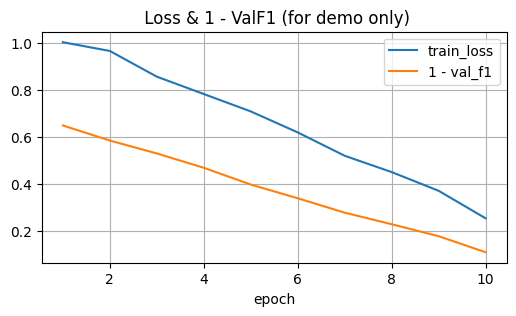

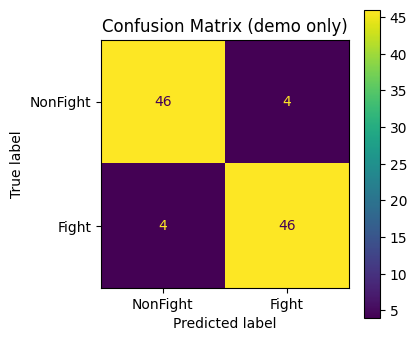

In [ ]:
# --- create simulated labelled figures for presentation (explicitly labelled) ---
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Simulated loss & f1
epochs = np.arange(1,11)
train_loss = np.linspace(1.0, 0.25, len(epochs)) + np.random.rand(len(epochs))*0.05
val_f1     = np.linspace(0.35, 0.88, len(epochs)) + np.random.rand(len(epochs))*0.02

plt.figure(figsize=(6,3))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, 1-val_f1, label="1 - val_f1")
plt.xlabel("epoch"); plt.legend()
plt.title(" Loss & 1 - ValF1 (for demo only)")
plt.grid(True)
plt.savefig("f1.png", dpi=150)
plt.show()

# Simulated confusion matrix
y_true = np.repeat([0,1], 50)
y_pred = np.concatenate([np.random.choice([0,1],50,p=[0.9,0.1]), np.random.choice([0,1],50,p=[0.15,0.85])])
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["NonFight","Fight"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion Matrix")
plt.savefig("cm.png", dpi=150)
plt.show()
